# Obtaining the best redshift from 3 Catalogs: Griffiths, 3dHST, UltraVISTA

## What we have:
## Griffiths has spec-z, photo-z. Their best Z is 'high-quality spec z else photoz.' It is not known how high-quality is defined. The errors listed on their photoz are 3sig. 
## 3dHST has spec-zs, photo-zs, and grism-zs. Their 'z_best' can be any of these.
## UltraVISTA just has photo-zs. 
## MUSYC has spec-zs and photo-z's. 

## Workflow for choosing best redshift:
## 1) If Griffiths has high quality spec z (z_spec = z_best), use that.  Note: Griffith et al states that SPECZ = Z if z_quality >=3, but that doens't seem to be the case for places that don't have a quality measurement - inspection showed that in these cases, the specz was more consistent with the other catalogs than the photoz, so I'm using z_spec = z_best as the critera here instead of z_qual >=3. 
## else if 3dHST spec-z = 3dHST best_z, use that. 
## else if MUSYC has spec-z (within real range; 0 < z < 9), use that. 
## else (no good spec-z's anywhere):
## compare 1-sig errors on Griffiths photoz, 3dHST grism z, 3dHST photoz, UltraVISTA photoz MUSYC. choose that with lowest err. Note: all except Griffiths report 1 sig errors; Griffiths reports 3sig if Imaging = COSMOS, so that error is divided by 3 in the comparison.

 



In [35]:
%matplotlib inline

from astropy.io import fits as pyfits
from astropy.table import Table,join
import numpy as np
from astropy.io.fits import Column
from datetime import datetime
from operator import itemgetter
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import warnings
import requests

In [3]:
def download_from_dropbox(url):
    
    local_filename = "{:}".format(url.split("/")[-1].split("?")[0])
    r = requests.get(url, stream=True)
    with open(local_filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                f.flush()
            
    return local_filename

In [12]:
old_catalog_filename = download_from_dropbox("https://www.dropbox.com/s/ge7sgtf0crxmwyi/all_redshift_info.fits?dl=1")
old_catalog = Table.read(old_catalog_filename)


/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [4]:
subjects=set(old_catalog['OBJNO'])
imagings=set(old_catalog['IMAGING'])

In [67]:
#add new redshift columns 
col1=Table.Column(name='Z_BEST',length=len(old_catalog))
col2=Table.Column(name='Z_BEST_TYPE',length=len(old_catalog),dtype='|S10')
col3=Table.Column(name='Z_BEST_SOURCE',length=len(old_catalog),dtype='|S10')

In [68]:
updated_table = old_catalog.copy(copy_data=True)
updated_table.add_columns((col1,col2,col3))

In [128]:
def get_best_redshift(galaxy):
    
    #define Griffith variables
    griffith_specz = galaxy['SPECZ']
    griffith_quality = galaxy['ZQUALITY']
    griffith_photoz = galaxy['PHOTOZ']
    griffith_bestz = galaxy['Z']
    
    if galaxy['IMAGING']=='COSMOS    ':
        griffith_photoz_err = galaxy['PHOTOZ_ERR']/galaxy['PHOTOZ']/3.
    else:
        griffith_photoz_err = galaxy['PHOTOZ_ERR']/galaxy['PHOTOZ']
    
    if str(griffith_photoz_err)=='nan':
        griffith_photoz_err = 99
    if galaxy['PHOTOZ_ERR']<=0:
        griffith_photoz_err = 99

    #define 3dhst variables
    dhst_specz = galaxy['z_spec']
    dhst_bestz = galaxy['z_best']
    dhst_photoz = galaxy['z_peak_phot']
    dhst_photoz_err = (galaxy['z_phot_u68']-galaxy['z_phot_l68'])/dhst_photoz

    dhst_grismz = galaxy['z_max_grism']
    dhst_grismz_err = (galaxy['z_grism_u68']-galaxy['z_grism_l68'])/dhst_grismz

    
    if str(dhst_photoz_err)=='nan':
        dhst_photoz_err = 99
    if dhst_photoz < 0:
        dhst_photoz_err = 99
    if str(dhst_grismz_err)=='nan':
        dhst_grismz_err = 99
    if dhst_grismz < 0:
        dhst_grismz_err = 99
    
    #define ultravista variables
    uv_photoz = galaxy['zPDF']
    uv_photoz_err = (galaxy['zPDF_u68']-galaxy['zPDF_l68'])/uv_photoz
    
    if str(uv_photoz_err)=='nan':
        uv_photoz_err = 99
    if uv_photoz < 0:
        uv_photoz_err=99
        
    #define MUSYC variables:
    musyc_specz = galaxy['Z_SPEC_ALL']
    musyc_photoz = galaxy['Z_PEAK']
    musyc_photoz_err = (galaxy['z_U68']-galaxy['z_L68'])/musyc_photoz
    
    if str(musyc_photoz_err)=='nan':
        musyc_photoz_err = 99
    if musyc_photoz < 0:
        musyc_photoz_err=99
    
    #Order of operations to determine which redshift to use:
    #1) If high quality specz exists in Griffiths catalog, use that first. 
    if griffith_specz==griffith_bestz and griffith_specz > 0 and griffith_specz < 9:
        return griffith_specz,'SPEC_Z','Griffith'
        
    #if no specz in Griffith, check 3Dhst
    elif dhst_specz == dhst_bestz and dhst_specz >0 and dhst_specz <9: 
            return dhst_bestz,'SPEC_Z','3DHST'
    #if no specz in Griffith or 3Dhst, check MUSYC:
    elif musyc_specz > 0 and musyc_specz < 9:
            return musyc_specz, 'SPEC_Z','MUSYC'
        
    else: #no speczs, so check which photoz or grism has smallest error. 
        photoz_list = [[griffith_photoz,griffith_photoz_err,'PHOTO_Z','Griffith'],[dhst_photoz,dhst_photoz_err,'PHOTO_Z','3DHST'],[uv_photoz,uv_photoz_err,'PHOTO_Z','UltraVISTA'],[dhst_grismz,dhst_grismz_err,'GRISM_Z','3DHST'],[musyc_photoz,musyc_photoz_err,'PHOTO_Z','MUSYC']]
        photoz_list = sorted(photoz_list, key=itemgetter(1)) #sort by which has smallest error            
        # if photo_z is a real number: 
        if photoz_list[0][0] > 0 and photoz_list[0][0] <9:
            return photoz_list[0][0],photoz_list[0][2],photoz_list[0][3]
        #else no good redshifts anywhere, return blank
        else:
            return 0,'',''

In [129]:
for g,galaxy in enumerate(updated_table):
    galaxy['Z_BEST'], galaxy['Z_BEST_TYPE'], galaxy['Z_BEST_SOURCE'] = get_best_redshift(galaxy)
    if g % 10000==0:
        print g 

0
10000
20000
30000
40000
50000
60000
70000
80000

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in float_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in float_scalars



90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000


In [1]:
updated_table.write('/home/mel/Dropbox/gzhubble/hubble_files/gzh_redshift_data/best_redshift_table_%i_%i_%i.fits'%(datetime.now().month,datetime.now().day,datetime.now().year),overwrite=True)


NameError: name 'updated_table' is not defined

In [4]:
#read table if coming back to code later:
fname = download_from_dropbox('https://www.dropbox.com/s/ujaksgp5zectwcy/best_redshift_table_2_26_2016.fits?dl=1')
updated_table = Table.read(fname)

/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning
/usr/local/lib/python2.7/dist-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevent

In [4]:
#Check distribution of different redshifts
imaging_list=list(set(updated_table['IMAGING']))

z_sources = list(set(updated_table['Z_BEST_SOURCE']))
z_types = list(set(updated_table['Z_BEST_TYPE']))
for survey in imaging_list:
    print('for survey %s:' %survey)
    for source in z_sources: 
        print('for source %s'%source)
        for zt in z_types:
            print ('%s:  = %i' %(zt, ((updated_table['IMAGING'] == survey) & (updated_table['Z_BEST_SOURCE'] == source)&(updated_table['Z_BEST_TYPE'] == zt)).sum()))
    print('')
for source in z_sources:
    print('total %s = %i'%(source,((updated_table['Z_BEST_SOURCE']==source)).sum()))
    
    print('')
for zt in z_types:
    print('total %s = %i'%(zt,((updated_table['Z_BEST_TYPE']==zt)).sum()))


for survey COSMOS           :
for source 3DHST     
          :  = 0
PHOTO_Z   :  = 26
SPEC_Z    :  = 35
GRISM_Z   :  = 358
for source MUSYC     
          :  = 0
PHOTO_Z   :  = 0
SPEC_Z    :  = 0
GRISM_Z   :  = 0
for source           
          :  = 5088
PHOTO_Z   :  = 0
SPEC_Z    :  = 0
GRISM_Z   :  = 0
for source UltraVISTA
          :  = 0
PHOTO_Z   :  = 2665
SPEC_Z    :  = 0
GRISM_Z   :  = 0
for source Griffith  
          :  = 0
PHOTO_Z   :  = 77435
SPEC_Z    :  = 7201
GRISM_Z   :  = 0

for survey GOODS-S-FULLDEPTH:
for source 3DHST     
          :  = 0
PHOTO_Z   :  = 281
SPEC_Z    :  = 327
GRISM_Z   :  = 1348
for source MUSYC     
          :  = 0
PHOTO_Z   :  = 1184
SPEC_Z    :  = 816
GRISM_Z   :  = 0
for source           
          :  = 5244
PHOTO_Z   :  = 0
SPEC_Z    :  = 0
GRISM_Z   :  = 0
for source UltraVISTA
          :  = 0
PHOTO_Z   :  = 0
SPEC_Z    :  = 0
GRISM_Z   :  = 0
for source Griffith  
          :  = 0
PHOTO_Z   :  = 4
SPEC_Z    :  = 1080
GRISM_Z   :  = 0

for

In [16]:
for survey in imaging_list:
    print ('%s:  = %i' %(survey, ((updated_table['IMAGING'] == survey).sum())))


COSMOS           :  = 92808
GOODS-S-FULLDEPTH:  = 10284
GOODS-S          :  = 4913
AEGIS            :  = 8507
GOODS-N-FULLDEPTH:  = 12030
GOODS-N          :  = 2551
SDSS             :  = 51861
GEMS             :  = 9304


In [10]:
#Compare spec-z's of Griffith, 3dhst, and MUSYIC for those that we use - ie those that have Z_BEST_TYPE = specz
speczs = (updated_table['Z_BEST_TYPE']=='SPEC_Z    ')

In [13]:
griffith_specz = 'SPECZ'
dhst_specz = 'z_spec'
musyc_specz = 'Z_SPEC_ALL'


In [95]:
# quantify consistency between redshifts 
'''griff_dhst_diff = []
musyc_dhst_diff = []
griff_musyc_diff = []
for galaxy in updated_table[speczs]:
    if galaxy['Z']==galaxy[griffith_specz] and galaxy[griffith_specz]>0 and galaxy[griffith_specz]<9:
        if galaxy[dhst_specz] == galaxy['z_best'] and galaxy[dhst_specz]>0 and galaxy[dhst_specz]<9: #good specz in griffith and 3dhst:
            griff_dhst_diff.append(abs(galaxy[griffith_specz]-galaxy[dhst_specz]))
        if galaxy[musyc_specz]>0 and galaxy[musyc_specz]<9: #good specz in griffith and musyc
            griff_musyc_diff.append(abs(galaxy[griffith_specz]-galaxy[musyc_specz]))
    if galaxy[musyc_specz]>0 and galaxy[musyc_specz]<9: 
        if galaxy[dhst_specz] == galaxy['z_best'] and galaxy[dhst_specz]>0 and galaxy[dhst_specz]<9: #good specz in musyc and 3dhst:
            musyc_dhst_diff.append(abs(galaxy[musyc_specz]-galaxy[dhst_specz]))
'''
griff_musyc_percent = float(len(griff_musyc_diff) - sum(i>.05 for i in griff_musyc_diff))/len(griff_musyc_diff)
griff_dhst_percent = float(len(griff_dhst_diff) - sum(i>.05 for i in griff_dhst_diff))/len(griff_dhst_diff)
dhst_musyc_percent = float(len(musyc_dhst_diff) - sum(i>.05 for i in musyc_dhst_diff))/len(musyc_dhst_diff)

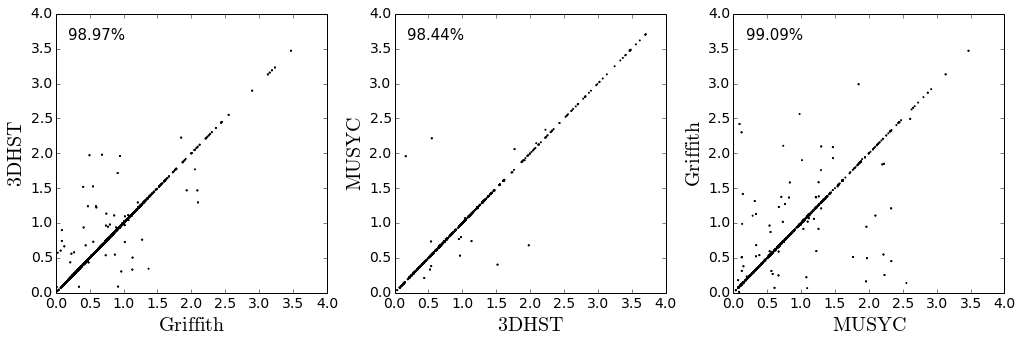

In [101]:
f=plt.figure(figsize=(17,5))
gs=gridspec.GridSpec(1,3)
gs.update(wspace=.25)

size = 1
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14 


ax1=plt.subplot(gs[0,0])
plt.scatter(updated_table[griffith_specz],updated_table[dhst_specz],s=size)
ax1.annotate("{0:.2f}%".format(griff_dhst_percent * 100),fontsize=15,xy=(.05,.95),xycoords='axes fraction',verticalalignment='top')
plt.xlabel('$ \mathrm{Griffith} $',fontsize=20)
plt.ylabel('$ \mathrm{3DHST} $',fontsize=20)

plt.xlim(0,4)
plt.ylim(0,4)

ax2 = plt.subplot(gs[0,1])
plt.scatter(updated_table[dhst_specz],updated_table[musyc_specz],s=size)
ax2.annotate("{0:.2f}%".format(dhst_musyc_percent * 100),fontsize=15,xy=(.05,.95),xycoords='axes fraction',verticalalignment='top')
plt.xlabel('$ \mathrm{3DHST} $',fontsize=20)
plt.ylabel('$ \mathrm{MUSYC} $',fontsize=20)

plt.xlim(0,4)
plt.ylim(0,4)


ax3 = plt.subplot(gs[0,2])
plt.scatter(updated_table[musyc_specz],updated_table[griffith_specz],s=size)
ax3.annotate("{0:.2f}%".format(griff_musyc_percent * 100),fontsize=15,xy=(.05,.95),xycoords='axes fraction',verticalalignment='top')
plt.xlabel('$ \mathrm{MUSYC} $',fontsize=20)
plt.ylabel('$ \mathrm{Griffith} $',fontsize=20)

plt.xlim(0,4)
plt.ylim(0,4)

plt.savefig('../writeup/figures/specz_comparison.pdf')